In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,BatchNormalization, Flatten, Dense, Dropout

In [ ]:
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MRI BTD Classification dataset','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MRI BTD Classification dataset','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:13<00:00,  5.41it/s]


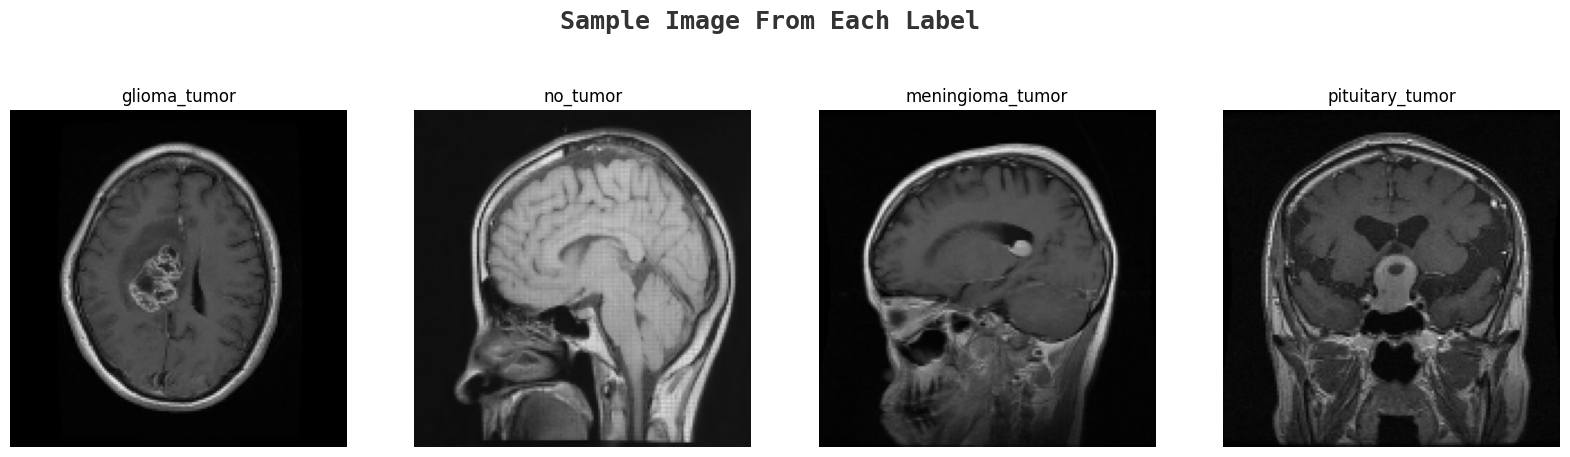

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
X_train.shape

(2946, 150, 150, 3)

In [ ]:
X_test.shape

(328, 150, 150, 3)

In [ ]:
y_train.shape

(2946,)

In [ ]:
y_test.shape

(328,)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)

# Find unique class labels
unique_labels = np.unique(y_test_labels)

print("Unique class labels:", unique_labels)

Unique class labels: [0 1 2 3]


In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.787384 to fit



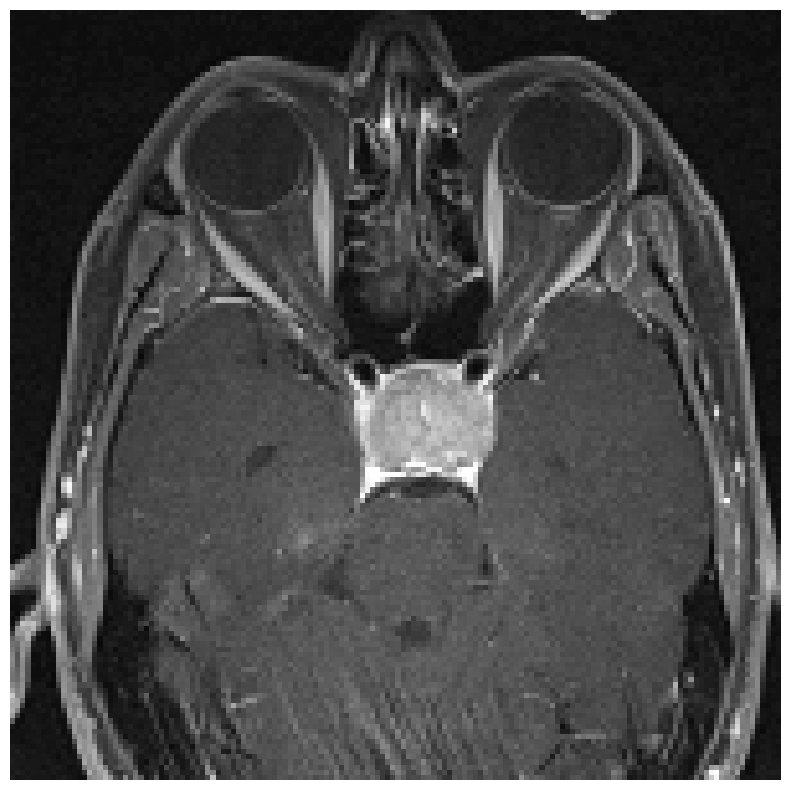

In [ ]:
plot_model(model, show_shapes=True, dpi=150)

# Display the plot
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
83/83 [==============================] - ETA: 0s - loss: 0.4853 - accuracy: 0.8118
Epoch 1: val_accuracy improved from -inf to 0.88814, saving model to effnet.keras
83/83 [==============================] - 429s 5s/step - loss: 0.4853 - accuracy: 0.8118 - val_loss: 0.3079 - val_accuracy: 0.8881 - lr: 0.0010
Epoch 2/5
83/83 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9438
Epoch 2: val_accuracy did not improve from 0.88814
83/83 [==============================] - 388s 5s/step - loss: 0.1675 - accuracy: 0.9438 - val_loss: 0.2978 - val_accuracy: 0.8847 - lr: 0.0010
Epoch 3/5
83/83 [==============================] - ETA: 0s - loss: 0.1389 - accuracy: 0.9559
Epoch 3: val_accuracy improved from 0.88814 to 0.91525, saving model to effnet.keras
83/83 [==============================] - 395s 5s/step - loss: 0.1389 - accuracy: 0.9559 - val_loss: 0.2532 - val_accuracy: 0.9153 - lr: 0.0010
Epoch 4/5
83/83 [==============================] - ETA: 0s - loss: 0.0994 

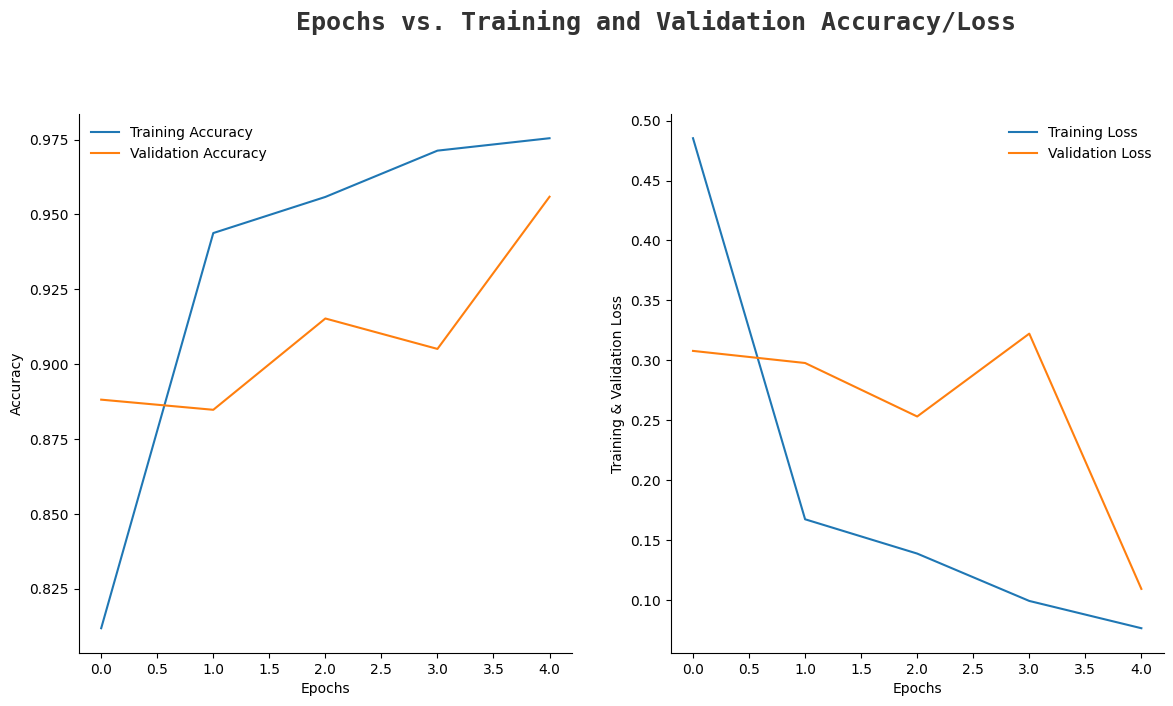

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(5)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss,label ='Training Loss')
ax[1].plot(epochs, val_loss, label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 14s 1s/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86        97
           1       0.91      0.98      0.94        51
           2       0.82      0.96      0.88        89
           3       1.00      0.96      0.98        91

    accuracy                           0.91       328
   macro avg       0.92      0.92      0.92       328
weighted avg       0.92      0.91      0.91       328



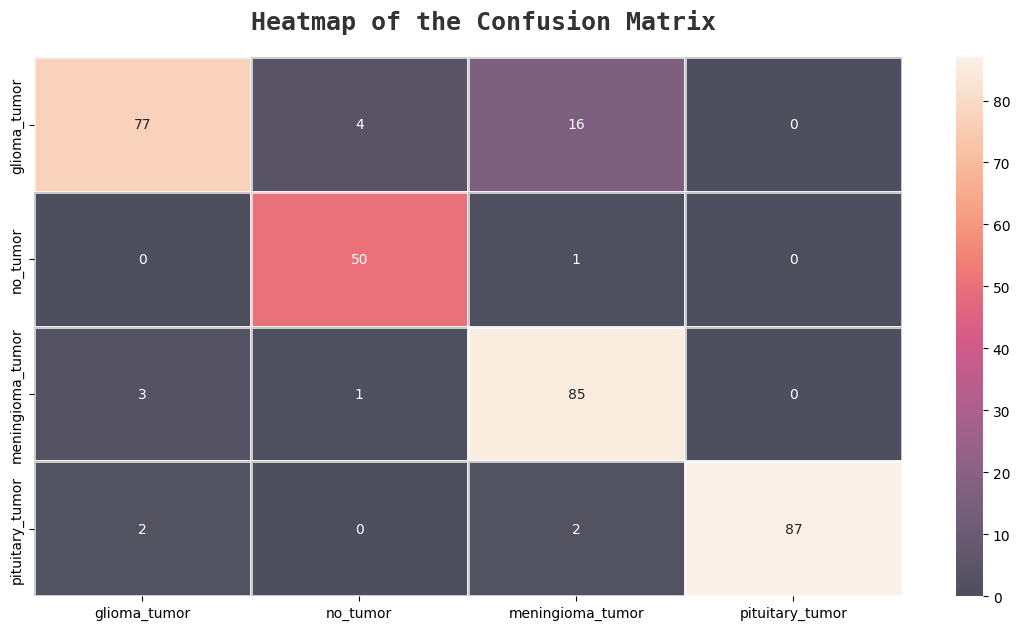

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

**Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Define the input shape based on your data
# Example: Assuming your input data has 100 features
input_shape = (100,)

# Create a new sequential model for DNN
model_dnn = Sequential()

# Add Dense layers
model_dnn.add(Dense(256, activation='relu', input_shape=input_shape))  # Input shape is now defined
model_dnn.add(Dropout(0.5))
model_dnn.add(Dense(128, activation='relu'))
model_dnn.add(Dropout(0.5))
model_dnn.add(Dense(64, activation='relu'))
model_dnn.add(Dense(4, activation='softmax'))  # Adjust the number of units for your specific classification problem

# Compile the model
model_dnn.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               25856     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                                 
Total params: 67268 (262.77 KB)
Trainable params: 67268 

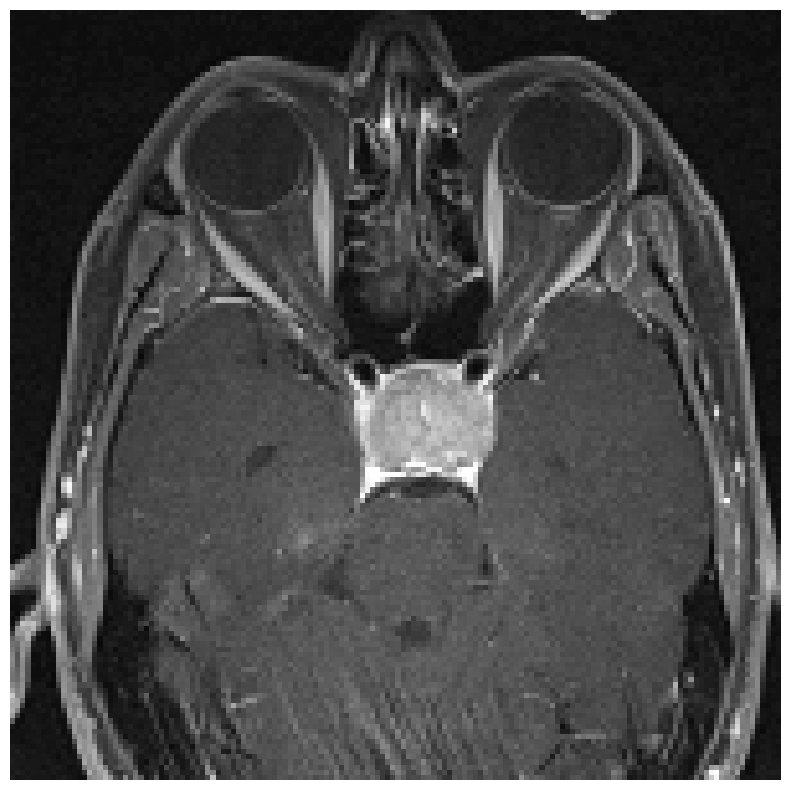

In [ ]:
plot_model(model_dnn, show_shapes=True, dpi=150)

# Display the plot
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
resized_X_train = []
for img in X_train:
    resized_img = cv2.resize(img, (224, 224))
    resized_X_train.append(resized_img)

resized_X_train = np.array(resized_X_train)

resized_X_test = []
for img in X_test:
    resized_img = cv2.resize(img, (224, 224))
    resized_X_test.append(resized_img)

resized_X_test = np.array(resized_X_test)

In [ ]:
model_dnn.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

# Define the input shape based on your resized images
input_shape = (224, 224, 3)

# Create a new sequential model
model_dnn = Sequential()

# Add convolutional layers to handle image data
model_dnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_dnn.add(MaxPooling2D((2, 2)))
model_dnn.add(Conv2D(64, (3, 3), activation='relu'))
model_dnn.add(MaxPooling2D((2, 2)))

# Flatten the output from convolutional layers for the Dense layers
model_dnn.add(Flatten())

# Add Dense layers
model_dnn.add(Dense(256, activation='relu'))
model_dnn.add(Dropout(0.5))
model_dnn.add(Dense(128, activation='relu'))
model_dnn.add(Dropout(0.5))
model_dnn.add(Dense(64, activation='relu'))
model_dnn.add(Dense(4, activation='softmax'))  # Adjust the number of units for your classification problem

# Compile the model
model_dnn.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model_dnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense_5 (Dense)             (None, 256)              

In [ ]:
# Change the loss function to 'categorical_crossentropy'
model_dnn.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model_dnn.fit(resized_X_train,y_train,validation_split=0.1, epochs =10, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/10
83/83 [==============================] - ETA: 0s - loss: 39.6406 - accuracy: 0.4236
Epoch 1: val_accuracy did not improve from 0.95593
83/83 [==============================] - 322s 4s/step - loss: 39.6406 - accuracy: 0.4236 - val_loss: 0.8326 - val_accuracy: 0.6949 - lr: 0.0010
Epoch 2/10
83/83 [==============================] - ETA: 0s - loss: 0.9286 - accuracy: 0.6492
Epoch 2: val_accuracy did not improve from 0.95593
83/83 [==============================] - 319s 4s/step - loss: 0.9286 - accuracy: 0.6492 - val_loss: 0.6173 - val_accuracy: 0.7729 - lr: 0.0010
Epoch 3/10
83/83 [==============================] - ETA: 0s - loss: 0.7225 - accuracy: 0.7439
Epoch 3: val_accuracy did not improve from 0.95593
83/83 [==============================] - 304s 4s/step - loss: 0.7225 - accuracy: 0.7439 - val_loss: 0.4988 - val_accuracy: 0.8339 - lr: 0.0010
Epoch 4/10
83/83 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.8159
Epoch 4: val_accuracy did not improve fr

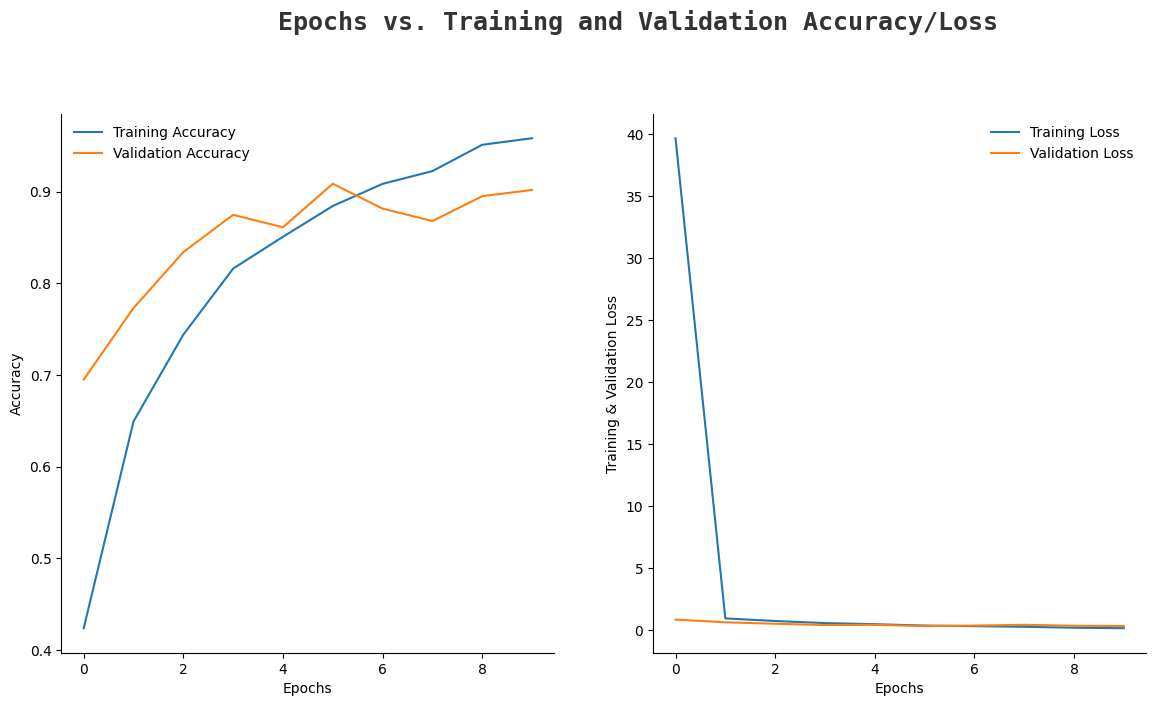

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(10)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss,label ='Training Loss')
ax[1].plot(epochs, val_loss, label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model_dnn.predict(resized_X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 15s 1s/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89        97
           1       0.93      0.82      0.87        51
           2       0.81      0.90      0.85        89
           3       0.93      1.00      0.96        91

    accuracy                           0.90       328
   macro avg       0.90      0.89      0.89       328
weighted avg       0.90      0.90      0.90       328



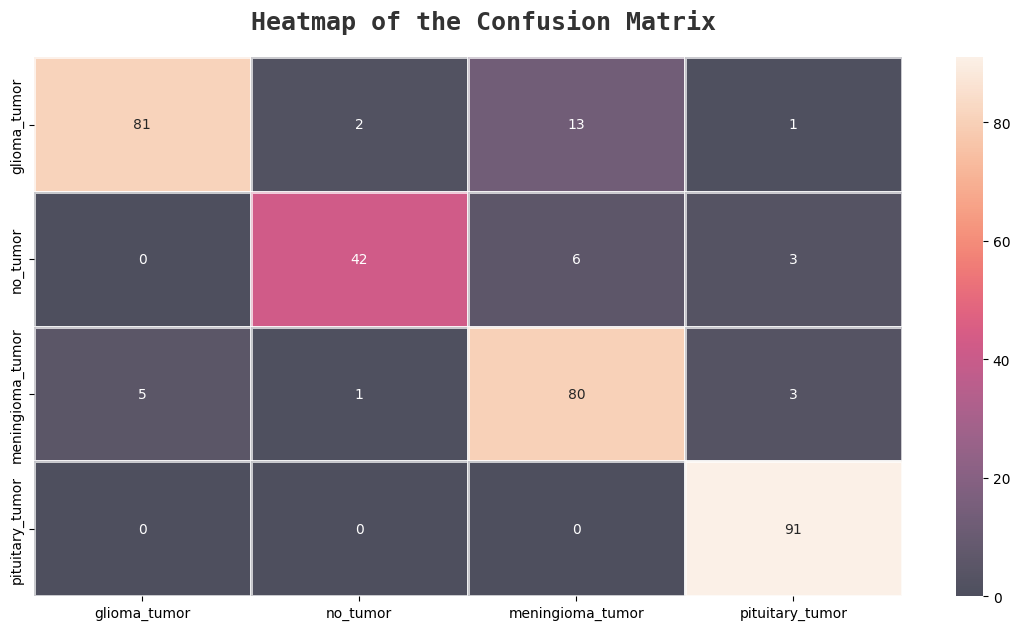

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

In [ ]:
model.save("/content/drive/MyDrive/MRI_classification_saved/brain_Dnn.h5")